# LeakyBucket model BMI demo

In this notebook we demonstrate the leakybucket Basic Model Interface. This BMI has the following model structure implemented:

<img src="diagram.png" alt="diagram" width="200"/>

The implementation can be found in `src/leakybucket/leakybucket_bmi.py`

To be able to initialize the BMI, we need a configuration file which contains the "leakiness" parameter, as well as the forcing file locations.

For forcing we use the eWaterCycle generic forcing generator. This can generate forcing data with ESMValTool from ERA5 data (if available on your machine), as well as CMIP6 data (which will be downloaded automatically).

In [1]:
from leakybucket.leakybucket_bmi import LeakyBucketBmi
from ewatercycle.base.forcing import GenericLumpedForcing
import ewatercycle.observation.grdc
import ewatercycle.analysis
from pathlib import Path
import pandas as pd
import numpy as np

shape = Path(ewatercycle.__file__).parent / "testing/data/Rhine/Rhine.shp"


grdc_station_id = "6335020"  # GRDC station ID
basin_name = "Rhine"

experiment_start_time="2000-01-01T00:00:00Z"
experiment_end_time="2000-12-31T00:00:00Z"


/opt/conda/envs/ewatercycle2/lib/python3.10/site-packages/esmvalcore/experimental/_warnings.py:13: UserWarning: 
  Thank you for trying out the new ESMValCore API.
  Note that this API is experimental and may be subject to change.
  More info: https://github.com/ESMValGroup/ESMValCore/issues/498


TEXT ABOUT CREATING FORCING

In [2]:
ERA5_forcing = GenericLumpedForcing.generate(
    dataset="ERA5",
    start_time=experiment_start_time,
    end_time=experiment_end_time,
    shape=shape.absolute(),
)

{'diagnostic': 'diagnostic',
 'variable_group': 'pr',
 'dataset': 'ERA5',
 'project': 'OBS6',
 'mip': 'day',
 'short_name': 'pr',
 'alias': 'ERA5',
 'frequency': 'day',
 'long_name': 'Precipitation',
 'modeling_realm': ['atmos'],
 'original_short_name': 'pr',
 'preprocessor': 'pr',
 'recipe_dataset_index': 0,
 'standard_name': 'precipitation_flux',
 'tier': 3,
 'timerange': '2000/2000',
 'type': 'reanaly',
 'units': 'kg m-2 s-1',
 'version': 1}
session: 'ewcrepn_wg324o_20240325_133732'.
{'diagnostic': 'diagnostic',
 'variable_group': 'tas',
 'dataset': 'ERA5',
 'project': 'OBS6',
 'mip': 'day',
 'short_name': 'tas',
 'alias': 'ERA5',
 'frequency': 'day',
 'long_name': 'Near-Surface Air Temperature',
 'modeling_realm': ['atmos'],
 'original_short_name': 'tas',
 'preprocessor': 'tas',
 'recipe_dataset_index': 0,
 'standard_name': 'air_temperature',
 'tier': 3,
 'timerange': '2000/2000',
 'type': 'reanaly',
 'units': 'K',
 'version': 1}
session: 'ewcrepn_wg324o_20240325_133732'.
{'diagnos

Now we have the forcing data available we can prepare the configuration file:

In [3]:
experiment_config_file = f"""{{
    "precipitation_file": "{ERA5_forcing.directory / ERA5_forcing.pr}",
    "temperature_file": "{ERA5_forcing.directory / ERA5_forcing.tas}",
    "leakiness": 0.05
}}
"""

with open("ERA5_leakybucket_config.json", "w") as f:
    f.write(experiment_config_file)

With the configuration file ready, we can define the model and initialize it. To clearly indicate that we are creating an instance of the class ```LeakyBucketBMI``` we use ```experiment_model``` as the name for the model object for this (demo) experiment.

In [4]:
experiment_model = LeakyBucketBmi()
experiment_model.initialize(config_file="ERA5_leakybucket_config.json")

In [7]:
experiment_model.get_current_time()

946728000

We can now use the `.update()` method to advance the model one time step.
After updating the model, we can request the current discharge using `.get_value("discharge")`.

We store this discharge in a list. For plotting, we also request the current model time (which is in seconds since 1970), and covert that to a pandas Timestamp.

In [8]:
discharge = []
time = []
while experiment_model.get_current_time() < experiment_model.get_end_time():
    experiment_model.update()
    discharge_this_timestep = experiment_model.get_value("discharge", np.array([0.]))
    discharge.append(discharge_this_timestep[0])
    time.append(pd.Timestamp(experiment_model.get_current_time(), unit="s"))

We can plot the output discharge directly

Text(0.5, 0, 'Time')

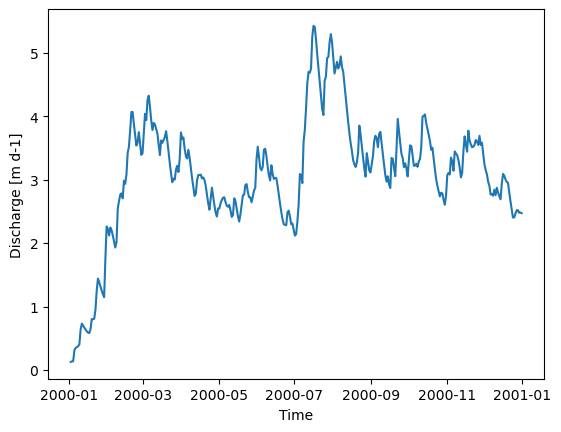

In [9]:
import matplotlib.pyplot as plt
plt.plot(time, discharge)

plt.ylabel(f"Discharge [{experiment_model.get_var_units('discharge')}]")
plt.xlabel("Time")

Now we can plot our hydrograph.

Note that the unit of discharge is in mm/d. Conversion to m3/s requires the area of the catchment.

In [10]:
discharge_dataframe = pd.DataFrame({'model output': discharge}, index=pd.to_datetime(time))
discharge_dataframe

,model output
2000-01-02 12:00:00,0.127518
2000-01-03 12:00:00,0.135801
2000-01-04 12:00:00,0.137414
2000-01-05 12:00:00,0.311857
2000-01-06 12:00:00,0.349709
...,...
2000-12-27 12:00:00,2.516473
2000-12-28 12:00:00,2.518818
2000-12-29 12:00:00,2.478482
2000-12-30 12:00:00,2.480763


In [11]:

observations_df, metadata = ewatercycle.observation.grdc.get_grdc_data(
    station_id=grdc_station_id,
    start_time=experiment_start_time,
    end_time=experiment_end_time,
)
grdc_obs = observations_df.rename(columns={"streamflow": "Observations from GRDC"})
grdc_lon = metadata["grdc_longitude_in_arc_degree"]
grdc_lat = metadata["grdc_latitude_in_arc_degree"]

In [12]:
observations_df.index

DatetimeIndex(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04',
               '2000-01-05', '2000-01-06', '2000-01-07', '2000-01-08',
               '2000-01-09', '2000-01-10',
               ...
               '2000-12-22', '2000-12-23', '2000-12-24', '2000-12-25',
               '2000-12-26', '2000-12-27', '2000-12-28', '2000-12-29',
               '2000-12-30', '2000-12-31'],
              dtype='datetime64[ns]', name='time', length=366, freq=None)

In [13]:
hydro_data = pd.concat([discharge_dataframe, grdc_obs], axis=1)
hydro_data

,model output,Observations from GRDC
2000-01-01 00:00:00,NaN,6010.0
2000-01-02 00:00:00,NaN,5330.0
2000-01-02 12:00:00,0.127518,NaN
2000-01-03 00:00:00,NaN,4700.0
2000-01-03 12:00:00,0.135801,NaN
...,...,...
2000-12-29 12:00:00,2.478482,NaN
2000-12-30 00:00:00,NaN,2300.0
2000-12-30 12:00:00,2.480763,NaN
2000-12-31 00:00:00,NaN,2210.0


/opt/conda/envs/ewatercycle2/lib/python3.10/site-packages/HydroErr/HydroErr.py:6248: UserWarning: Row(s) [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 22

(<Figure size 1000x1000 with 2 Axes>,
 (<Axes: title={'center': 'Hydrograph'}, ylabel='Discharge (m$^3$ s$^{-1}$)'>,
  <Axes: >))

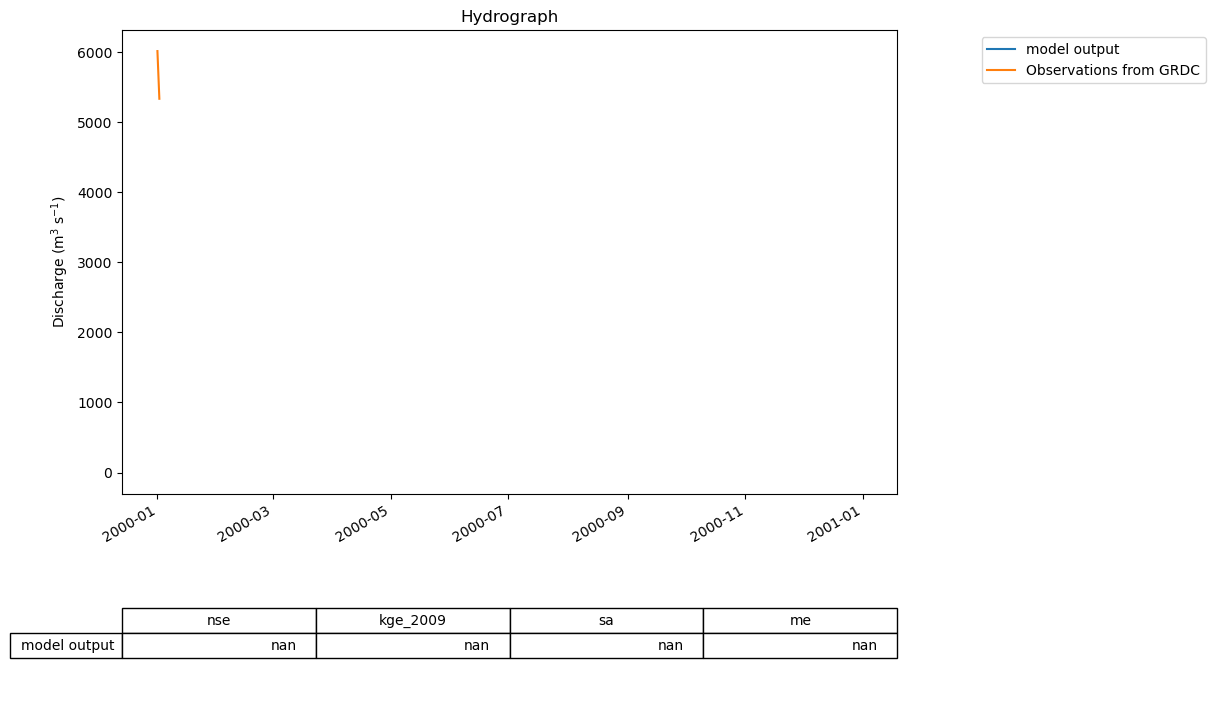

In [14]:


# Plot hydrograph and show metrics
ewatercycle.analysis.hydrograph(hydro_data, reference='Observations from GRDC', filename = 'experiment_hydrograph.png')

It is good practice to remove a model object when done using ```.finalize()```. For small models like this, it doesn't matter too much, but larger models that run in containers keep using resources when not ```finalized```.

In [ ]:
experiment_model.finalize()